In [229]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from tifffile import imwrite, imsave
import datetime
from numba import jit, njit, prange
from functools import partial
import time 


In [89]:
image = imread('3-CrXAS-movie@577-5eV.tif')

In [317]:
@partial(jit, nopython=True)
def swap(x, t_args):
    return np.transpose(x, t_args)

@njit
def tile_image(imframe: np.ndarray, tilesize: tuple):
    """Returns an array of image tiles with shape (Y, X, n, m) where Y is the tile row number, X is the tile column
    number, n is the tile pixel height and m is the tile pixel width"""
    img_height, img_width = imframe.shape
    tileheight, tilewidth = tilesize
    imcopy = imframe.copy() #workaround for numba reshape not supporting non-contiguous arrays
    tiled_array = imcopy.reshape(img_height // tileheight, tileheight, img_width // tilewidth, tilewidth)
    out_array = swap(tiled_array,(0,2,1,3))
    return out_array

@njit
def reform_image(tilearray: np.ndarray, originalsize: tuple):
    """Reforms an image from a tile array with shape (Y, X, n, m) where Y is the tile row number, X is the tile column
    number, n is the tile pixel height and m is the tile pixel width.  Returns an image with the shape of the original imag"""
    
    reordered = swap(tilearray,(0,2,1,3))
    contiguous = reordered.copy() #numba doesn't support numpy reshaping of non-congiguous arrays so you have to copy it as a workaround
    reformed = contiguous.reshape(originalsize)
    return reformed

@njit
def linalg_test(solvematrix, zmatrix):
    coefs = np.linalg.lstsq(solvematrix, zmatrix)[0]
    return coefs

@njit
def plane_level_njit(img: np.ndarray):
    """Takes a 2d image (numpy array), calculates the mean plane, and returns that 2d image after subtracting the
    mean plane"""

    """Create x, y, and z (pixel intensity) arrays"""
    dimensions = img.shape
    totalpoints = dimensions[0] * dimensions[1]
    xarray = np.linspace(0, totalpoints - 1, totalpoints) % dimensions[0]
    yarray = np.linspace(0, dimensions[1] - 1, totalpoints)  # a sequence that makes y values that correspond to the z points
    flatimg = img.flatten()+0.0

    """Calculate the best fit plane through the datapoints"""
    cvals = xarray*0+1.0  #make the cvals floats

    xyc = np.column_stack((xarray, yarray, cvals))
    coefs = np.linalg.lstsq(xyc, flatimg)[0]  #njit and lstsq require all the datatypes to be the same

    leveled_flat = flatimg-((coefs[0]*xarray+coefs[1]*yarray+coefs[2])-np.mean(flatimg))

    final_img = leveled_flat.reshape(img.shape)
    return final_img

@njit
def median_prominence_threshold(imgarray, prominence):
    """Takes an input array and thresholds it using median + prominence"""
    brlevel = np.median(imgarray)
    threshold = brlevel + prominence
    thresholded = (imgarray > threshold)
    
    
    return thresholded

@njit(parallel=True)
def batch_level_segment(image: np.array, tileshape: tuple, imageshape: tuple):
    segmented_timeseries = np.zeros(image.shape)

    for frameid in range(image.shape[0]):
        
        frame = image[frameid,:,:]
        tiles = tile_image(frame, tileshape)
        segmented = np.zeros(tiles.shape)

        for i in prange(tiles.shape[0]):
            for j in prange(tiles.shape[1]):
                tile = tiles[i,j,:,:]
                leveltile = plane_level_njit(tile)
                segmentedtile = median_prominence_threshold(leveltile,8000)
                segmented[i,j,:,:] = segmentedtile


        reformed = reform_image(segmented, imageshape)
        segmented_timeseries[frameid,:,:] = reformed.astype(np.uint8)
        print(frameid)

    return segmented_timeseries

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


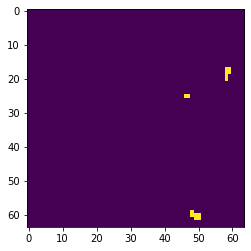

In [320]:
test = median_prominence_threshold(image[0,0:64,0:64],8000)

print(test)
test_int = test.astype(int)
plt.imshow(test_int)

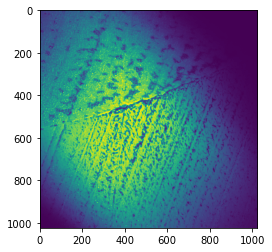

In [279]:
tiles = tile_image(image[0,:,:],(64,64))
reformed = reform_image(tiles,(1024,1024))
plt.imshow(reformed)

In [295]:
output = batch_level_segment(image,(64,64), (1024,1024))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268


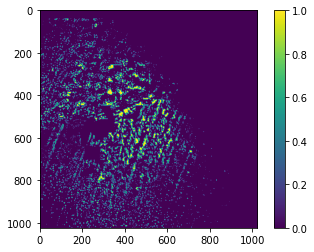

In [332]:
total = output.astype(np.uint8)
imsave("new_segmentation_test.tif", total)
plt.imshow(total[180,:,:])
plt.colorbar()


(array([989089.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  59487.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

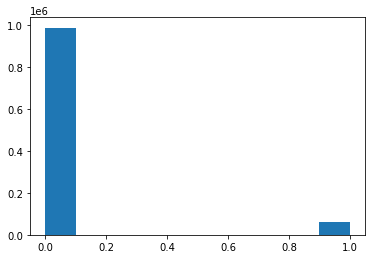

In [331]:

plt.hist(total[180,:,:].flatten())

In [187]:
xyc = np.random.rand(1024, 3)
z = np.random.rand(1024)
print(type(xyc[0,0]), type(z[0]))
linalg_test(xyc, z)

<class 'numpy.float64'> <class 'numpy.float64'>


array([0.30252677, 0.32982413, 0.27041283])

In [228]:
@njit(parallel=True)
def test_parallel(rangetest):
    for i in prange(rangetest.shape[0]):
        for j in prange(rangetest.shape[1]):
            plane_level_njit(rangetest[i,j,:,:])
            median_prominence_threshold(rangetest,0.5)


def test_unparallel(rangetest):
    for i in range(rangetest.shape[0]):
        for j in range(rangetest.shape[1]):
            plane_level_njit(rangetest[i,j,:,:])
            median_prominence_threshold(rangetest,0.5)    


In [232]:
array = np.random.rand(16,16,64,64)
t0 = time.perf_counter()
test_unparallel(array)
t1 = time.perf_counter()
test_parallel(array)
t2 = time.perf_counter()

print("regular execution took ", t1-t0)
print("njit took ", t2-t1)

regular execution took  4.416823888999716
njit took  1.967757331998655


(4096, 3)
(4096, 3) (4096,)
regular execution took  0.11986941600116552
njit took  0.0014171589991747169


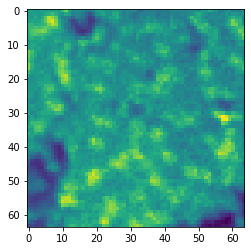

In [215]:
jittest = image[0,:,:]
tiles = tile_image(jittest,(64,64))
reformed = reform_image(tiles,jittest)
t0 = time.perf_counter()
leveltile = plane_level(tiles[2,2,:,:])
t1 = time.perf_counter()
leveltile = plane_level_njit(tiles[2,2,:,:])
t2 = time.perf_counter()

print("regular execution took ", t1-t0)
print("njit took ", t2-t1)

plt.imshow(leveltile.astype(int))
